In [1]:
import numpy as np
import datetime

import matplotlib.pyplot as plt

from scipy.optimize import minimize

import astropy.units as u
from astropy.wcs import WCS
from astropy.time import Time
from astropy.table import Table, join, vstack, hstack
from astropy.io import fits
from astropy.visualization.wcsaxes.frame import EllipticalFrame
from astropy.coordinates import SkyCoord

from photutils import CircularAperture

from skycam_utils.astrometry import update_altaz, load_wcs
from skycam_utils.photometry import load_skycam_catalog, load_mask, match_stars
from skycam_utils.pipeline import process_stellacam_image
from skycam_utils.fit_wcs import wcs_zea, wcs_refine_zea
from skycam_utils.fisheye_map import Fisheye, distortion_mapper, distortion_mapper_looper

In [2]:
skycat = load_skycam_catalog()

In [3]:
hdul = fits.open("data_0003285.fits.gz")
im = hdul[0].data
hdr = hdul[0].header
hdr

SIMPLE  =                    T / Created with PDL (http://pdl.perl.org)         
BITPIX  =                    8                                                  
NAXIS   =                    2                                                  
NAXIS1  =                  640                                                  
NAXIS2  =                  480                                                  
BUNIT   = 'Data Value'                                                          
DATAMAX =         2.550000E+02                                                  
DATAMIN =         0.000000E+00                                                  
GAIN    =                  106                                                  
FRAME   = '256 Frames'                                                          
DATE    = '2012-01-22'                                                          
UT      = '08:36:59'                                                            
LST     = '09:17:53.047'    

In [4]:
#dt = datetime.datetime.strptime(hdr['UT'], "%a %b %d %H:%M:%S %Y")
tobs = Time(f"{hdr['DATE']}T{hdr['UT']}", scale='utc')
tobs

<Time object: scale='utc' format='isot' value=2012-01-22T08:36:59.000>

In [5]:
skycat = update_altaz(skycat, time=tobs)

In [6]:
wcs_initial = load_wcs(year=2012)

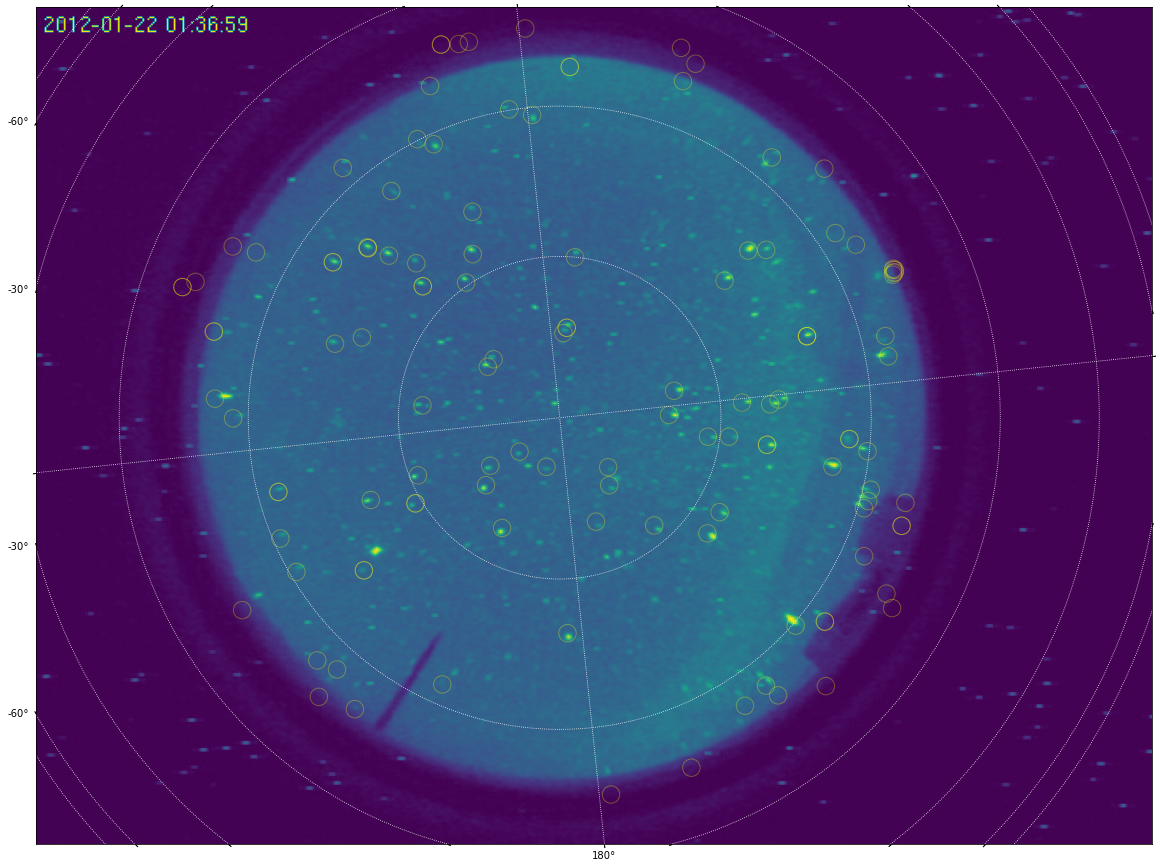

In [7]:
plt.figure(figsize=[20,20])
skycat = skycat[skycat['Alt'] > 10.0]
skycat = skycat[skycat['Magnitude'] < 5]
pred_x, pred_y = wcs_initial.all_world2pix(skycat['Az'], skycat['Alt'], 0)
pred_aps = CircularAperture((pred_x, pred_y), r=5.)
ax = plt.subplot(projection=wcs_initial)
ax.imshow(im, origin='lower')
ax.coords[0].set_format_unit(u.deg)
ax.coords[0].set_auto_axislabel(False)
ax.coords[1].set_auto_axislabel(False)
ax.grid(color='white', ls='dotted')
pred_aps.plot(color='yellow', lw=1., alpha=0.3)
plt.show()

In [8]:
mask = load_mask(year=2012)

In [9]:
bkg_image, diff_image, segm, sky_mag, catalog = process_stellacam_image("data_0003285.fits.gz", wcs=wcs_initial, mask=mask, write=True, zp=0)

In [10]:
matched = match_stars(skycat, catalog, wcs_initial, max_sep=2.5*u.deg)

In [11]:
matched

HD,Vmag,U-B,B-V,V-R,R-I,V-Rc,Rc-Ic,u_mag,g_mag,r_mag,i_mag,z_mag,Star Name,Identity,SAO,FK5,Magnitude,Spectral class,pm_RA,pm_Dec,RA,Dec,Alt,Az,id,xcentroid,ycentroid,source_sum,background_mean,obs_mag
,,,,,,,,,,,,,,,,,,,,,,,deg,deg,,pix,pix,,,
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str17,str25,int64,int64,float64,str17,float64,float64,float64,float64,float64,float64,int64,float64,float64,uint64,float64,float64
76756,--,--,--,--,--,--,--,--,--,--,--,--,Acubens,Alpha Cancri,98267,337,4.25,A5m,0.034,-0.031,134.62175,11.8577833,69.65553377757693,193.28056069170154,28,322.4247246022032,181.86046511627907,817,84.16401478101602,-7.280555141331039
89025,3.44,0.19,0.31,0.31,0.19,0.19,0.19,4.9,3.52,3.41,3.44,3.49,Adhafera,Zeta Leonis,81265,384,3.44,F0III,0.018,-0.007,154.1725667,23.4173117,74.42111616413021,118.66578585074522,41,258.8052527254708,214.8731417244797,2018,78.48453033665018,-8.262302904752229
116842,--,--,--,--,--,--,--,--,--,--,--,--,Alcor,80 Ursae Majoris,28751,--,4.01,A5V,0.118,-0.016,201.30625,54.98805,41.2867282644282,42.45792547803969,106,189.736160188457,341.9893992932862,3396,77.5210634789039,-8.827419203929788
29139,--,--,--,--,--,--,--,--,--,--,--,--,Aldebaran,Alpha Tauri,94027,168,0.85,K5+III,0.063,-0.19,68.98,16.5091667,25.104530290663387,274.5927467194055,74,485.197824184069,279.670876578717,7997,76.44143385960473,-9.757317740043156
89484,--,--,--,--,--,--,--,--,--,--,--,--,Algieba,Gamma Leonis,81298,--,2.61,K1-IIIbFe-0.5,0.306,-0.147,154.993,19.8416667,71.55468163861747,126.45389227617069,35,256.31199538638987,203.3659169550173,3468,78.9092350802159,-8.850197722010432
112185,--,--,--,--,--,--,--,--,--,--,--,--,Alioth,Epsilon Ursae Majoris,28553,483,1.77,A0pCr,0.112,-0.006,193.507,55.9597167,45.585098326268096,40.51680559944366,101,201.16978744939271,338.2601214574899,3952,76.54671862483544,-8.992042339788975
120315,1.86,-0.68,-0.19,-0.12,-0.18,-0.09,-0.12,1.87,1.66,2.07,2.4,2.65,Alkaid,Eta Ursae Majoris,44752,509,1.86,B3V,-0.122,-0.011,206.8851572,49.3132667,37.60627091517581,49.59272549115727,98,170.5815443768023,333.2896507529638,3121,78.03541398997238,-8.73573442166333
47105,1.92,0.05,0.0,0.06,-0.01,0.01,0.0,3.02,1.83,2.04,2.25,2.42,Almeisan,Gamma Geminorum,95912,251,1.93,A0IV,0.042,-0.042,99.4279606,16.3992806,50.78692788050833,256.5755232425168,49,421.5372124492558,228.18782138024358,3695,102.05684080981092,-8.919036106827111


In [12]:
dmag = matched['obs_mag'] - matched['Magnitude']
#matched = matched[dmag > -11]
dmag.mean(), dmag.std()

(-11.079493114492246, 0.6506895599451347)

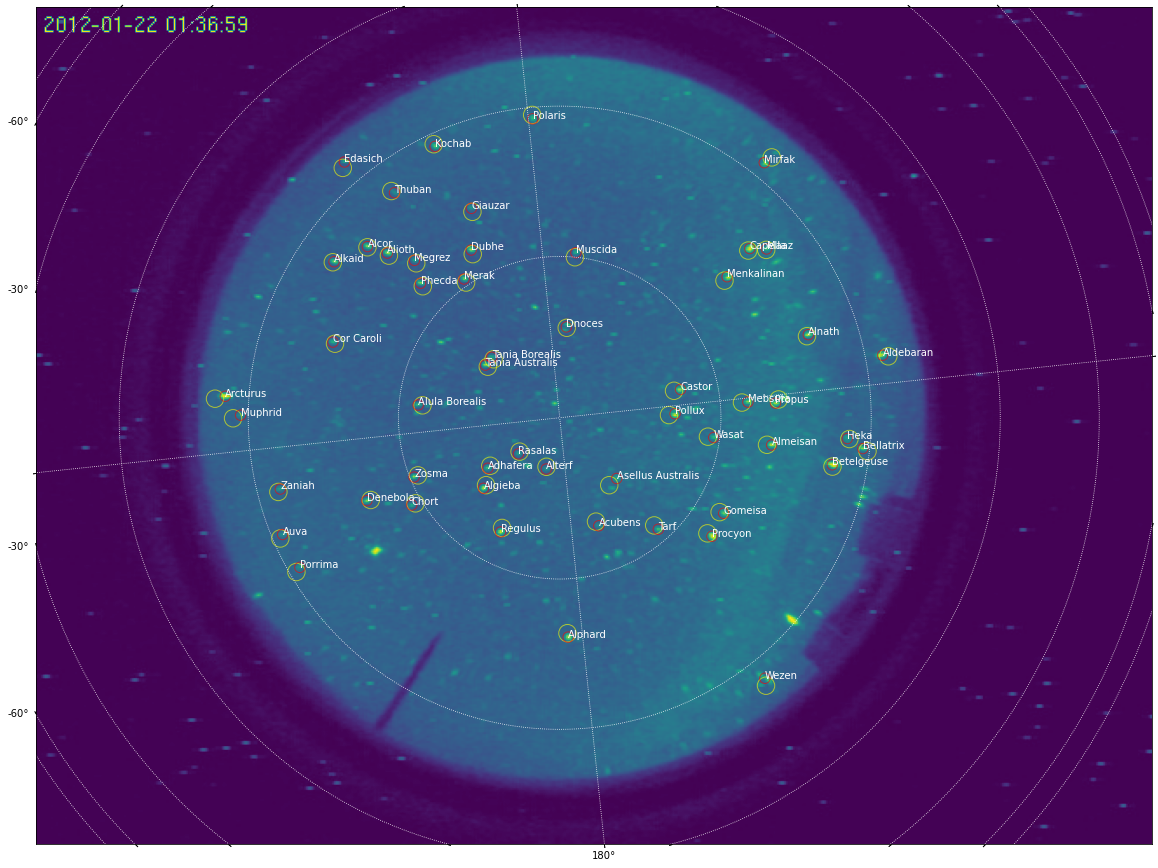

In [13]:
plt.figure(figsize=[20,20])
pred_x, pred_y = wcs_initial.all_world2pix(matched['Az'], matched['Alt'], 0)
pred_aps = CircularAperture((pred_x, pred_y), r=5.)
meas_aps = CircularAperture((matched['xcentroid'], matched['ycentroid']), r=3.)
ax = plt.subplot(projection=wcs_initial)
ax.imshow(im, origin='lower')
ax.coords[0].set_format_unit(u.deg)
ax.coords[0].set_auto_axislabel(False)
ax.coords[1].set_auto_axislabel(False)
ax.grid(color='white', ls='dotted')
pred_aps.plot(color='yellow', lw=1., alpha=0.6)
meas_aps.plot(color='red', lw=1, alpha=0.6)
for row in matched:
    ax.annotate(row['Star Name'], (row['xcentroid'].value, row['ycentroid'].value), color='white')
plt.show()